In [130]:
import os 
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_groq.chat_models import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="Gemma2-9b-It")

In [132]:
llm.invoke("hi").content

'Hi there! 👋  How can I help you today?\n'

In [133]:
@tool 
def multiply(firstnum: int, secondnum: int) -> int:
    """This function will multiply two numbers"""
    return firstnum * secondnum

In [134]:
multiply.invoke({"firstnum": 2, "secondnum": 2})

4

In [135]:
@tool 
def search(query: str):
    """Perform the web search on user query"""
    tavily = TavilySearchResults()
    return tavily.invoke(query)

In [136]:
search.invoke({"query": "Who is the president of india?"})

[{'url': 'https://en.wikipedia.org/wiki/President_of_India',
  'content': 'The **president of India** ([ISO](https://en.wikipedia.org/wiki/ISO_15919 "ISO 15919"): _Bhārata kē Rāṣṭrapati_) is the [head of state](https://en.wikipedia.org/wiki/Head_of_state "Head of state") of the [Republic of India](https://en.wikipedia.org/wiki/Republic_of_India "Republic of India"). The president is the nominal head of the executive,[[a]](https://en.wikipedia.org/wiki/President_of_India#cite_note-3) the first citizen of the country, and the [supreme [...] | President of India |\n| --- |\n| _Bhārata kē Rāṣṭrapati_ |\n| [![Image 5](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/President_of_India_Logo.png/330px-President_of_India_Logo.png)](https://en.wikipedia.org/wiki/File:President_of_India_Logo.png) Logo of the President of India | [...] *   **President of India**\n\n*   [Droupadi Murmu](https://en.wikipedia.org/wiki/Droupadi_Murmu "Droupadi Murmu") ([15th](https://en.wikipedia.org/wiki/Li

In [137]:
tools = [multiply, search]

In [138]:
model_with_tool = llm.bind_tools(tools)

In [139]:
tool_mapping = {tool.name: tool for tool in tools}

In [140]:
tool_mapping

{'multiply': StructuredTool(name='multiply', description='This function will multiply two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000002E221519120>),
 'search': StructuredTool(name='search', description='Perform the web search on user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002E2214B7380>)}

In [141]:
response = model_with_tool.invoke("who is the current president of usa?")

In [142]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qh1z7fhkh', 'function': {'arguments': '{"query":"who is the current president of usa"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1072, 'total_tokens': 1157, 'completion_time': 0.154545455, 'prompt_time': 0.037740873, 'queue_time': 0.245281127, 'total_time': 0.192286328}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd31cd5e-5835-497a-9dc9-2e135cd1241c-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the current president of usa'}, 'id': 'qh1z7fhkh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1072, 'output_tokens': 85, 'total_tokens': 1157})

In [143]:
tool_details = response.additional_kwargs.get('tool_calls')

In [144]:
tool_details

[{'id': 'qh1z7fhkh',
  'function': {'arguments': '{"query":"who is the current president of usa"}',
   'name': 'search'},
  'type': 'function'}]

In [145]:
tool_details[0]["function"]["name"]

'search'

In [146]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the current president of usa"}'

In [147]:
import json

json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the current president of usa'}

================

In [148]:
from typing import Annotated, Sequence, List, TypedDict, operator
from langgraph.graph.message import BaseMessage
import json

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [149]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]
    print("**************")
    print(messages)
    return {"messages": [model_with_tool.invoke(question)]}

In [150]:
def invoke_tool(state:AgentState):
    tool_details = state['messages'][-1].additional_kwargs.get('tool_calls', [])[0]
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f"Selected tool: {tool_details.get("function").get("name")}")
    
    if tool_details.get("function").get("name") == "search":
        response = input(prompt=f"[y/n] continue with expensive web search")
        if response == 'n':
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return{"messages": [response]}

In [151]:
def router(state: AgentState):
    tool_call = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_call):
        return "tools"
    else:
        return "end"

In [152]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tools", invoke_tool)

graph.add_edge(START, "ai_assistant")

graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tools": "tools",
        "end": END
    }
)

graph.add_edge("tools", END)

app = graph.compile()

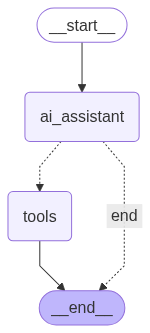

In [153]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [154]:
app.invoke({"messages": ["who is upcoming president of USA?"]})

**************
['who is upcoming president of USA?']
Selected tool: search


{'messages': ['who is upcoming president of USA?',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't94hnaxw1', 'function': {'arguments': '{"query":"upcoming president of the USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1071, 'total_tokens': 1153, 'completion_time': 0.149090909, 'prompt_time': 0.046417895, 'queue_time': 0.246420747, 'total_time': 0.195508804}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c18bd5be-d02d-4d7d-9839-9ec541a8593a-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of the USA'}, 'id': 't94hnaxw1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1071, 'output_tokens': 82, 'total_tokens': 1153}),
  [{'url': 'https://www.britannica.com/event/United-States-presidential-election-of-2024',
    'content': '**United States presidential election of 2024**, Ameri

In [155]:
   
for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

**************
['who is upcoming president of USA?']
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qn2e262h4', 'function': {'arguments': '{"query":"upcoming president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1071, 'total_tokens': 1154, 'completion_time': 0.150909091, 'prompt_time': 0.041089746, 'queue_time': 0.24542589699999998, 'total_time': 0.191998837}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dd6d2335-0866-4fbc-9db7-798e66266c89-0', tool_calls=[{'name': 'search', 'args': {'query': 'upcoming president of USA'}, 'id': 'qn2e262h4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1071, 'output_tokens': 83, 'total_tokens': 1154})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.britannica.com/event/United-States-presidential-election-of-2024', 'content': '**Un

====================================================================

In [161]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_groq.chat_models import ChatGroq

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [158]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="Gemma2-9b-It")

In [160]:
tavily = TavilySearchResults()

In [162]:
@tool 
def multiply(a: int, b: int):
    """multiply two numbers"""
    return a * b

In [163]:
tools = [tavily, multiply]

In [164]:
llm_with_tools = llm.bind_tools(tools)

In [184]:
def invoke_model(state: MessagesState):
    messages = state['messages'][-1].content
    print("---------------")
    print(messages)
    print("-----------------")
    return {"messages": [llm_with_tools.invoke(messages)]}

In [185]:
memory = MemorySaver()

In [186]:
graph = StateGraph(MessagesState)

graph.add_node("ai_assistant", invoke_model)
graph.add_node("tools", ToolNode(tools))

graph.add_conditional_edges(
    "ai_assistant",
    tools_condition
)

graph.set_entry_point("ai_assistant")
graph.add_edge("tools", "ai_assistant")

app = graph.compile(checkpointer=memory,
                    interrupt_before=["tools"]
                    )

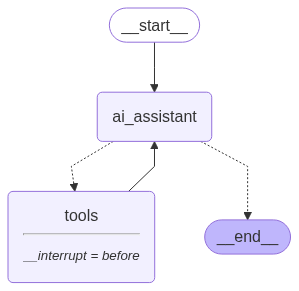

In [187]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [188]:
config = {"configurable": {"thread_id": "1"}}

In [189]:
inputs = {"messages": ["who is the current president of india?"]}

for events in app.stream(inputs, config=config, stream_mode="values"):
    for key, value in events.items():
        print(f"name: {key}")
        print(value)
        print("===========")

name: messages
[HumanMessage(content='who is the current president of india?', additional_kwargs={}, response_metadata={}, id='308c950e-4eff-4aaf-9600-2e53576cb666')]
---------------
who is the current president of india?
-----------------
name: messages
[HumanMessage(content='who is the current president of india?', additional_kwargs={}, response_metadata={}, id='308c950e-4eff-4aaf-9600-2e53576cb666'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '2xwr9m8v5', 'function': {'arguments': '{"query":"who is the current president of india"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1108, 'total_tokens': 1199, 'completion_time': 0.165454545, 'prompt_time': 0.038887114, 'queue_time': 0.24964136799999997, 'total_time': 0.204341659}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--87d8521a-5160-4a8f-9

In [190]:
events = app.stream(None, config=config, stream_mode="values")

In [192]:
for event in events:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2xwr9m8v5)
 Call ID: 2xwr9m8v5
  Args:
    query: who is the current president of india
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "http://www.rashtrapatibhavan.gov.in/about-us", "content": "The President of India is the head of state of the Republic of India. The President is the nominal head of the executive, the first citizen of the country, as well as the commander-in-chief of the Indian Armed Forces. Smt. Droupadi Murmu is the 15th and current President, having taken office from 25 July 2022.\n\n![Rashtrapati Bhavan](/sites/default/files/2023-03/aboutus.jpg \"Rashtrapati Bhavan\")"}, {"url": "https://en.wikipedia.org/wiki/President_of_India", "content": "Droupadi Murmu is the 15th and current president, having taken office on 25 July 2022."}, {"url": "https://www.jagranjosh.com/ge

In [196]:
inputs = {"messages": ["what is a weather there?"]}

events = app.stream(inputs, config=config, stream_mode="values")

In [197]:
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
---------------
what is a weather there?
-----------------
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (egeazsm3k)
 Call ID: egeazsm3k
  Args:
    query: weather there


In [202]:
snapshot = app.get_state(config=config)

In [204]:
snapshot.next

('tools',)

In [205]:
last_message = snapshot.values['messages'][-1]

In [206]:
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'egeazsm3k', 'function': {'arguments': '{"query":"weather there"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1106, 'total_tokens': 1192, 'completion_time': 0.156363636, 'prompt_time': 0.038944133, 'queue_time': 0.24667027000000002, 'total_time': 0.195307769}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e637eb3c-dc1a-483b-9cb2-d556d3641438-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather there'}, 'id': 'egeazsm3k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1106, 'output_tokens': 86, 'total_tokens': 1192})

In [207]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather there'},
  'id': 'egeazsm3k',
  'type': 'tool_call'}]

In [208]:
events = app.stream(None, config=config, stream_mode="values")

In [209]:
for event in events:
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (egeazsm3k)
 Call ID: egeazsm3k
  Args:
    query: weather there
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weather25.com/north-america/usa?page=date&date=14-6", "content": "|  | 00:00 | 03:00 | 06:00 | 09:00 | 12:00 | 15:00 | 18:00 | 21:00 |\n| --- |\n| Temperature | 66°F | 62°F | 60°F | 59°F | 60°F | 60°F | 60°F | 57°F | [...] | Chance of rain | 0% | 0% | 0% | 0% | 0% | 0% | 0% | 0% |\n| Precipitation | 0 in | 0 in | 0 in | 0 in | 0 in | 0 in | 0 in | 0 in |\n| Humidity | 77% | 81% | 96% | 89% | 92% | 90% | 94% | 96% |\n| Wind | 3 Miles | 4 Miles | 6 Miles | 6 Miles | 6 Miles | 6 Miles | 5 Miles | 6 Miles |\n| Wind Gust | 7 Miles | 7 Miles | 9 Miles | 8 Miles | 9 Miles | 9 Miles | 8 Miles | 8 Miles | [...] | Weather | ![Image 8: Partly cloudy](https://res.weather25.com/im

In [210]:
snapshot = app.get_state(config=config)

In [211]:
snapshot.next

('tools',)

In [212]:
last_messages = snapshot.values['messages'][-1]

last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'egeazsm3k', 'function': {'arguments': '{"query":"weather there"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1106, 'total_tokens': 1192, 'completion_time': 0.156363636, 'prompt_time': 0.038944133, 'queue_time': 0.24667027000000002, 'total_time': 0.195307769}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e637eb3c-dc1a-483b-9cb2-d556d3641438-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather there'}, 'id': 'egeazsm3k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1106, 'output_tokens': 86, 'total_tokens': 1192})

In [213]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather there'},
  'id': 'egeazsm3k',
  'type': 'tool_call'}]